**ИЕРАРХИЧЕСКАЯ КЛАСТЕРИЗАЦИЯ**

In [1]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline

import os

Читаем данные, меняем запятые на точки, и преобразуем к числовому признаку

In [2]:
df = pd.read_csv('Econom_Cities_data.csv', sep=';')

In [3]:
for col in ['Work', 'Price', 'Salary']:
    df[col] = df[col].astype(str).str.replace(',', '.').astype(float)

Строим гистограмму, чтобы понять, как распределены признаки

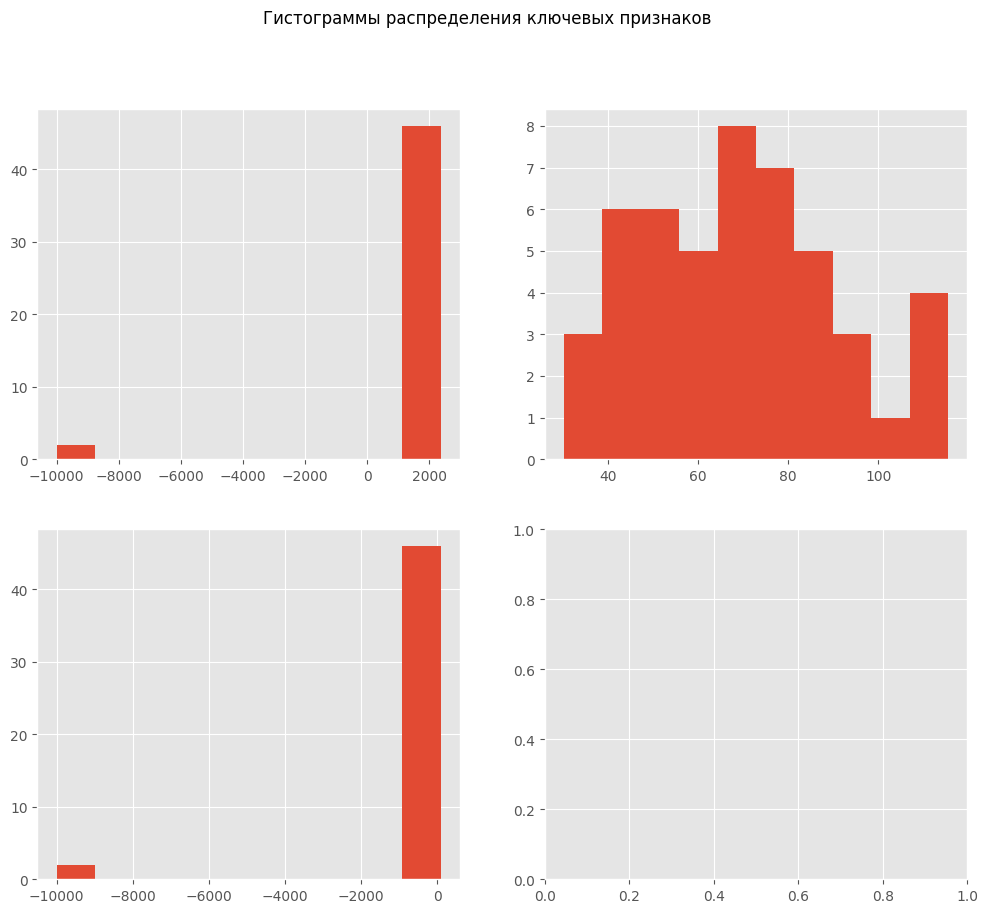

In [4]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

ax[0, 0].hist(df['Work'])
ax[0, 1].hist(df['Price'])
ax[1, 0].hist(df['Salary'])

fig.suptitle('Гистограммы распределения ключевых признаков')

plt.show()

На гистограммах отчеливо видны выбросы. Попробуем выполнить иерархическую кластеризацию на всех данных, с выбросами

Выполним стандартизацию:

In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = df[['Work', 'Price', 'Salary']].copy()
X[['Work', 'Price', 'Salary']] = scaler.fit_transform(X[['Work', 'Price', 'Salary']])

In [6]:
df.head()

,City,Work,Price,Salary
0,Amsterdam,1714.0,65.6,49.0
1,Athens,1792.0,53.8,30.4
2,Bogota,2152.0,37.9,11.5
3,Bombay,2052.0,30.3,5.3
4,Brussels,1708.0,73.8,50.5


Выполним иерархическую кластеризацию и построим дендрограмму

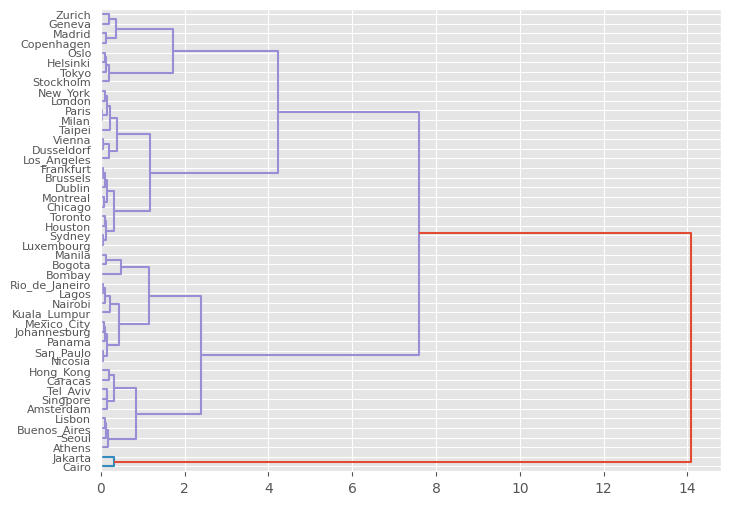

In [7]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

link = linkage(X, 'ward', 'euclidean')

fig = plt.figure(figsize=(8,6))
dn = dendrogram(link, labels= df['City'].tolist(), orientation='right')

Как и ожидалось, выбросы отделились в свой кластер, который только в последнюю очередь был присоединен к остальным данным. Выкинем выбросы, стандартизируем данные снова и выполним кластеризацию.

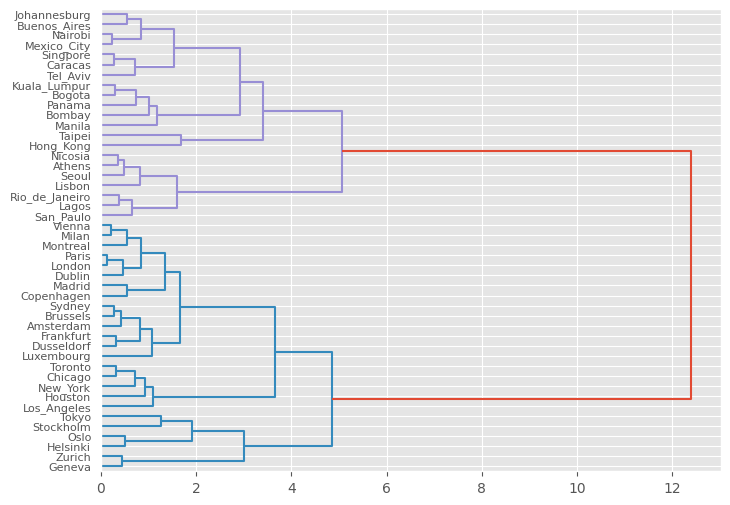

In [8]:
df_no_otliers = df[(df['City'] != 'Cairo') & (df['City'] != 'Jakarta')].copy()

scaler = StandardScaler()

X_no_outliers = df_no_otliers[['Work', 'Price', 'Salary']].copy()
X_no_outliers[['Work', 'Price', 'Salary']] = scaler.fit_transform(X_no_outliers[['Work', 'Price', 'Salary']])

link = linkage(X_no_outliers, 'ward', 'euclidean')

fig = plt.figure(figsize=(8,6))
dn = dendrogram(link, labels= df_no_otliers['City'].tolist(), orientation='right')

Построим "каменную осыпь"

Text(0, 0.5, 'Расстояние')

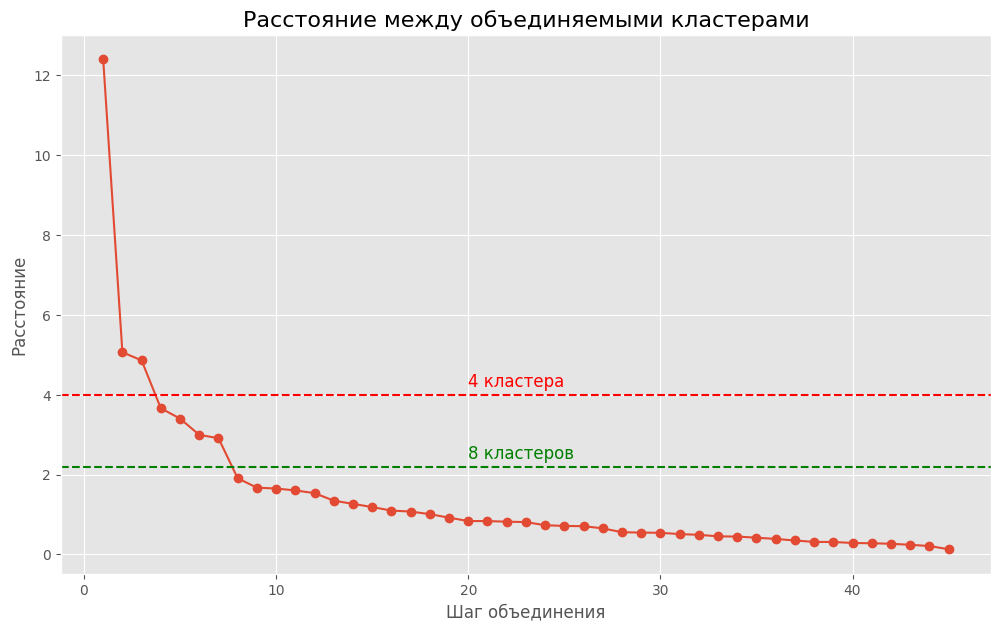

In [9]:
dist = link[:, 2]
dist_rev = dist[::-1]
idxs = range(1, len(dist) + 1)

fig, ax = plt.subplots(figsize=(12, 7))

ax.plot(idxs, dist_rev, marker='o', label='Расстояние объединения')
ax.axhline(y=4, color='red', linestyle='--', label='Уровень отсечения для 4 кластеров')
ax.text(20, 4.1, '4 кластера', color='red', fontsize=12, verticalalignment='bottom')
ax.axhline(y=2.2, color='green', linestyle='--', label='Уровень отсечения для 8 кластеров')
ax.text(20, 2.3, '8 кластеров', color='green', fontsize=12, verticalalignment='bottom')
ax.set_title('Расстояние между объединяемыми кластерами', fontsize=16)
ax.set_xlabel('Шаг объединения', fontsize=12)
ax.set_ylabel('Расстояние', fontsize=12)

Видно, что если остановить объединение на расстоянии 4, то получим 4 кластера. Судя по графику, эта точка кажется логичной для остановки деления

In [10]:
clusters = X_no_outliers.copy()
clusters['cluster'] = fcluster(link, 4, criterion='maxclust')
clusters[['Work', 'Price', 'Salary']] = scaler.inverse_transform(clusters[['Work', 'Price', 'Salary']])

In [11]:
clusters.groupby('cluster').mean()

,Work,Price,Salary
cluster,,,
1,1780.500000,108.550000,71.300000
2,1792.000000,77.526316,55.157895
3,1798.857143,50.942857,19.214286
4,2082.357143,53.121429,14.914286


При делении на 4 кластера можно строго проследить логику кластеризации.

В первый кластер попадают города высокими ценами, зарпалатами, также в этих горадах более гуманно относятся к работникам - количество часов меньше. 

Во второй кластер попадают города, в которых цены и зарплаты уже ниже. 

В третий и четвертый кластеры попадают схожие по зарплатам и ценам города - по сравнению с первыми двумя кластерами цены и зарплаты в них заметно ниже. Основное отличие в том, что в 4 кластере люди сильно перерабатывают.

Сделаем 8 кластеров

In [12]:
clusters2 = X_no_outliers.copy()
clusters2['cluster'] = fcluster(link, 8, criterion='maxclust')
clusters2[['Work', 'Price', 'Salary']] = scaler.inverse_transform(clusters2[['Work', 'Price', 'Salary']])
clusters2.groupby('cluster').mean()

,Work,Price,Salary
cluster,,,
1,1874.000000,97.950000,95.150000
2,1733.750000,113.850000,59.375000
3,1960.000000,75.820000,59.480000
4,1732.000000,78.135714,53.614286
5,1798.857143,50.942857,19.214286
6,2260.000000,74.050000,31.150000
7,2143.400000,40.180000,8.900000
8,1988.000000,56.385714,14.571429


Деление на 8 кластеров тоже имеет смысл, исходя из графика "каменная осыпь", но его уже сложнее рационализировать с точки зрения средних по признаку. В зависимости от бизнес постановки задачи его тоже можно использовать.

In [ ]:
from make_map import plot_clusters_on_map

plot_clusters_on_map(df_no_otliers, clusters, 'hierarchical_clusters_map_4.html')
plot_clusters_on_map(df_no_otliers, clusters2, 'hierarchical_clusters_map_8.html')
